<a href="https://colab.research.google.com/github/MarcoE25/Clases-Analisis-Datos/blob/main/Clase_4_intermedio_202508.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐼 Maestro en Pandas - Itinerario

* **Automatizaciones con funciones**: flujo de limpieza de datos, y adaptar al dataset de ejecutivos
* **Merges**: unión con tabla de ejecutivos
* **Filtros**: máscaras booleanas y consultas en Pandas
* **Group by**: agrupaciones para datos agregados
* **Gráficos directos**: barras y de dispersión
* **+POO**: Creación de una clase y una librería

---

# Automatización de la función

In [ ]:
import pandas as pd
from dateutil import parser
import datetime as dt
import random as r

# Webscraping
import urllib.request, json
from urllib.request import urlopen
from zipfile import ZipFile
import re

# Resumen clase anterior

* Automatización y robustecimiento de la función de limpieza.
* Integración con la función de valorización.
* Todo en un solo lugar, listo para crear nuestra propia librería.

In [ ]:
# Primera version
df_bank = pd.read_csv("https://cursopypagina.github.io/CursoPy/Clase_1.csv")

########################### Valorizacion #######################################
def divisa_webs(clave):
  # Leemos la web y docodificamos
  url = "https://www.piplatam.com/Home/filiales?country=MX"
  page = urlopen(url)
  htmlBytes = page.read()
  html = htmlBytes.decode("utf-8")

  # De todo el string anterior, buscamos el indice donde comienza
  # la clave que estamos buscando
  strValorClave = html.find(clave)
  stringFiltro1 = html[strValorClave:]

  # USD-MXN FIX (Banxico)","dblValue":18.6873,"dblChange":18.7072,"dblPerChange":-0.019899999999999807,"txtDate":"09/03"}
  strValor = stringFiltro1.split("dblValue")[1].split("dblChange")[0]

  # ":18.6873,"
  strValor = re.findall(r"\d+\.\d+", strValor)[0]
  return strValor

usdValor = round(float(divisa_webs("USD-MXN FIX (Banxico)")), 2)
eurValor = round(float(divisa_webs("EUR-MXN")), 2)

########################### Procesamiento ######################################
def clean_1(df_func):
  """
  Limpia y transforma un DataFrame con información de operaciones financieras.

  Parámetros
  ----------
  df_func : pandas.DataFrame
      DataFrame que contiene al menos las columnas:
      - 'Fecha_Fin'
      - 'Fecha_Inicio'
      - 'Plazo'
      - 'Nombre_Empresa'
      - 'Operacion'

  Procesos realizados
  -------------------
  1. Manejo de valores faltantes:
    - 'Fecha_Fin': se reemplazan nulos con '1900-01-01'.
    - 'Plazo': se reemplazan nulos con 0.

  2. Conversión de tipos de datos:
    - 'Plazo': se convierte a tipo entero.
    - 'Fecha_Fin' y 'Fecha_Inicio': se convierten a objetos datetime usando `dateutil.parser.parse`.

  3. Limpieza y normalización de texto:
    - 'Nombre_Empresa': se eliminan espacios extra y se formatea con mayúscula inicial en cada palabra.
    - 'Operacion': se eliminan prefijos "OP-" quedándose solo con el identificador posterior.

  4. Cálculo y asignación de fecha de reporte:
    - Se genera la fecha del día anterior a la ejecución en formato "YYYY-MM-DD".
    - Se agrega la columna 'Fecha_Reporte' con dicho valor.

  Valor devuelto
  --------------
  pandas.DataFrame
      El DataFrame transformado y limpio listo para análisis o procesos posteriores.
  """
  df_func_trabajo = df_func.copy()
  ############################# PROCESO DE LIMPIEZA ############################
  df_func_trabajo['Fecha_Fin'] = df_func_trabajo['Fecha_Fin'].fillna('1900-01-01')
  df_func_trabajo['Plazo'] = df_func_trabajo['Plazo'].fillna(0)
  df_func_trabajo['Plazo'] = df_func_trabajo['Plazo'].astype(int)
  listaFechas = ['Fecha_Fin', 'Fecha_Inicio']

  for col_fecha in listaFechas:
    df_func_trabajo[col_fecha] = df_func_trabajo[col_fecha].apply(lambda x: parser.parse(x))
  df_func_trabajo['Nombre_Empresa'] = df_func_trabajo['Nombre_Empresa'].str.strip().str.title()
  df_func_trabajo['Operacion'] = df_func_trabajo['Operacion'].str.split("-").apply(lambda x: x[1])

  ############################# AGREGAMOS COLUMNAS NUEVAS ######################
  fechaReporte = dt.datetime.today() - dt.timedelta(days = 1)
  fechaReporte = dt.datetime.strftime(fechaReporte, "%Y-%m-%d")
  df_func_trabajo['Fecha_Reporte'] = fechaReporte

  def valorizacion(divisa):
    """
    DOCUMENTACION
    """
    if divisa == "USD":
      return usdValor
    elif divisa == "EUR":
      return eurValor
    else:
      return 1

  df_func_trabajo['Valor_Divisa'] = df_func_trabajo['Divisa'].apply(valorizacion)
  df_func_trabajo['Monto_Credito_Val'] = df_func_trabajo['Valor_Divisa'] * df_func_trabajo['Monto_Credito']
  del df_func_trabajo['Monto_Credito']
  del df_func_trabajo['Valor_Divisa']

  zonas = ["NORTE", "SUR", "CENTRO"]
  df_func_trabajo['Zona'] = [r.choice(zonas) for i in range(0, len(df_func_trabajo))]

  return df_func_trabajo

In [ ]:
df_bank_clean = clean_1(df_bank)
df_bank_clean.head()

,Nombre_Empresa,Divisa,Operacion,Fecha_Inicio,Fecha_Fin,Plazo,Fecha_Reporte,Monto_Credito_Val,Zona
0,Grupo Bimbo,MXN,100000,2019-08-27,2023-04-24,1336,2025-09-03,4.117590e+06,CENTRO
1,Walmart De México,USD,100001,2017-04-10,2022-02-18,1775,2025-09-03,1.309801e+08,SUR
2,Liverpool,EUR,100002,2017-04-21,1900-01-01,0,2025-09-03,2.161170e+08,NORTE
3,Grupo Lala,USD,100003,2023-11-24,1900-01-01,0,2025-09-03,2.416698e+07,CENTRO
4,Femsa,EUR,100004,2024-10-30,1900-01-01,0,2025-09-03,1.553332e+08,SUR


In [ ]:
df_bank_ej = pd.read_csv("https://cursopypagina.github.io/CursoPy/Clase_1_5.csv")
df_bank_ej = df_bank_ej.rename(columns={'Fecha_Inicio_Contrato': 'Fecha_Inicio'})
df_bank_ej.head()

,Nombre_Empresa,Tipo,Divisa,Monto,Plazo,Fecha_Inicio,Ejecutivo
0,TELMEX,Vista,MXN,768489.72,1,2018-07-28,Daniel Escobedo Alcántar
1,TELMEX,Vista,EUR,4885585.41,1,2023-10-06,Alejandro Manuel Pantoja Olivo
2,GRUPO CARSO,CEDE,MXN,1858088.68,558,"January 31, 2020",Anabel Anel Quintanilla
3,WALMART DE MÉXICO,Vista,USD,2597613.53,1,"April 28, 2022",Irma Tomás Alfaro
4,GRUPO CARSO,Plazo,EUR,896807.16,321,13-Jul-2025,Frida Heredia Merino


In [ ]:
df_bank_clean_ej = clean_1(, 1)
df_bank_clean_ej.head()

KeyError: 'Fecha_Fin'

# Merges

In [ ]:
df_bank_ejec = pd.read_csv("https://cursopypagina.github.io/CursoPy/Clase_1_5.csv")
empresas = list(df_bank_clean['Nombre_Empresa'].unique())
df_bank_ejec['Nombre_Empresa'] = [r.choice(empresas) for i in range(len(df_bank_ejec))]
df_bank_ejec

,Nombre_Empresa,Tipo,Divisa,Monto,Plazo,Fecha_Inicio_Contrato,Ejecutivo
0,Femsa,Vista,MXN,768489.72,1,2018-07-28,Daniel Escobedo Alcántar
1,Cemex,Vista,EUR,4885585.41,1,2023-10-06,Alejandro Manuel Pantoja Olivo
2,Liverpool,CEDE,MXN,1858088.68,558,"January 31, 2020",Anabel Anel Quintanilla
3,Grupo Bimbo,Vista,USD,2597613.53,1,"April 28, 2022",Irma Tomás Alfaro
4,Grupo Carso,Plazo,EUR,896807.16,321,13-Jul-2025,Frida Heredia Merino
...,...,...,...,...,...,...,...
995,Grupo Lala,Plazo,MXN,143094.39,522,29/07/2017,Luis Manuel Ana María Vera Domínguez
996,Walmart De México,Vista,MXN,1672971.37,1,29/11/2020,Sandra Rodolfo Amador
997,Walmart De México,Plazo,EUR,2764276.29,273,10-Dec-2018,Eloisa Salinas Aguilar
998,Cemex,CEDE,MXN,3989370.60,187,2022-01-04,Juana Antonia Lira Samaniego


# Filtros

In [ ]:
df_bank_ejec.query("Plazo == 1")

,Nombre_Empresa,Tipo,Divisa,Monto,Plazo,Fecha_Inicio_Contrato,Ejecutivo
0,soriana,Vista,MXN,768489.72,1,2018-07-28,Daniel Escobedo Alcántar
1,grupo lala,Vista,EUR,4885585.41,1,2023-10-06,Alejandro Manuel Pantoja Olivo
3,soriana,Vista,USD,2597613.53,1,"April 28, 2022",Irma Tomás Alfaro
6,BANORTE,Vista,MXN,2221490.67,1,20/09/2022,Sr(a). Salma Esquivel
8,CEMEX,Vista,MXN,4360084.72,1,"April 15, 2016",Fernando Rivera Maestas
...,...,...,...,...,...,...,...
988,bbva méxico,Vista,USD,1337510.26,1,05-May-2022,Guillermo Cristian Hernandes
989,cemex,Vista,MXN,896530.02,1,"July 23, 2021",Samuel Yuridia Huerta
990,walmart de méxico,Vista,USD,2213211.09,1,2021-05-05,Juana Antonia Lira Samaniego
994,alsea,Vista,MXN,3918208.52,1,"October 17, 2018",Gabino Mariano Laureano Puente


# Group by

# Gráficos directos

<Axes: xlabel='Divisa'>

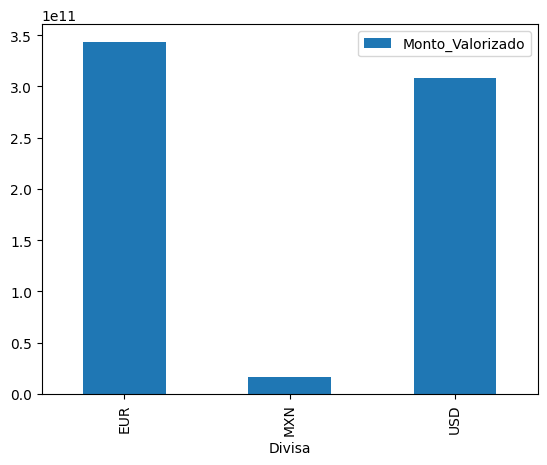

In [ ]:
df_bank_clean[['Divisa', 'Monto_Credito', 'Monto_Valorizado']].groupby("Divisa").sum().reset_index().plot.bar(x='Divisa', y='Monto_Valorizado')

<Axes: xlabel='Plazo', ylabel='Monto_Credito'>

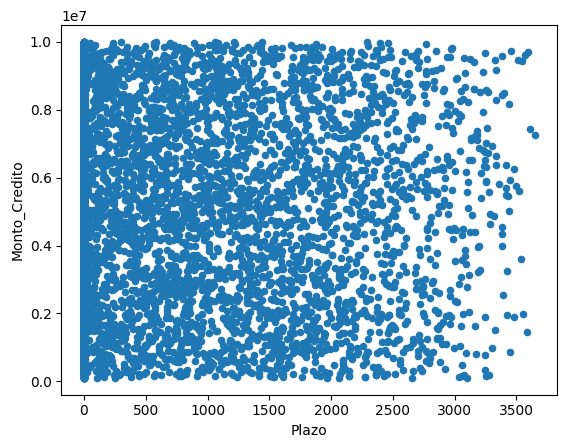

In [ ]:
df_bank_clean.plot.scatter(x='Plazo', y='Monto_Credito')

# POO